# Bibliotecas

In [1]:
import inflection
import math
import pickle

import numpy        as np
import pandas       as pd
import seaborn      as sns

from ydata_profiling import ProfileReport

from matplotlib      import pyplot       as plt

c:\Users\mello\anaconda3\envs\ros\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importação de dados

In [2]:
df_sales = pd.read_csv( '../data/train.csv', low_memory=False )
df_store = pd.read_csv( '../data/store.csv', low_memory=False )

# merge
df_00 = pd.merge( df_sales, df_store, how='left', on='Store' )

# 1.0 Descrição dos dados

In [3]:
df_01 = df_00.copy()

## 1.1. Renomear colunas

In [4]:
df_01.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Renomeando colunas:
df_01.columns = cols_new

In [6]:
df_01.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Tamanho do dataframe

In [7]:
print( 'Number of Rows: {}'.format( df_01.shape[0] ) )
print( 'Number of Cols: {}'.format( df_01.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Tipagem dos dados - Primeira iteração

In [8]:
print(df_01.dtypes)

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object


In [9]:
# Transformando variável 'date' em datetime:
df_01['date'] = pd.to_datetime( df_01['date'] )

print(df_01.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object


## 1.4. Checando dados vazios

In [10]:
print(df_01.isna().sum())

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64


## 1.5. Preenchendo dados vazios

In [11]:
#competition_distance - Transforma os Nan em 200000 (muito maior do que a maior distância máxima no banco de dados):     
df_01['competition_distance'] = df_01['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month - Caso seja NA, extrai o mês da coluna 'date':
df_01['competition_open_since_month'] = df_01.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year - Caso seja NA, extrai o ano da coluna 'date':
df_01['competition_open_since_year'] = df_01.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week - Caso seja NA, extrai a semana da coluna 'date':           
df_01['promo2_since_week'] = df_01.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year - Caso seja NA, extrai o ano da coluna 'date':           
df_01['promo2_since_year'] = df_01.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval - Cria uma coluna 'is_promo' para indicar se está dentro do período de promoção ou não.           
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'} # Cria o mapa de meses

df_01['promo_interval'].fillna(0, inplace=True ) # Transforma Nan em 0

df_01['month_map'] = df_01['date'].dt.month.map( month_map ) # Extrai o mês de 'date' e transforama em letras conforme o mapa

# Checa se o mês de 'month_map' está contido nos meses de 'promo_interval' e se estiver muda para 1 o valor de 'is_promo' indicando que está no período de promoção
df_01['is_promo'] = df_01[['promo_interval', 'month_map']].apply(
                                                                 lambda x: 
                                                                 0 if x['promo_interval'] == 0 
                                                                 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                                                 else 0, axis=1 
                                                                 )

C:\Users\mello\AppData\Local\Temp\ipykernel_20124\3203742446.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_01['promo_interval'].fillna(0, inplace=True ) # Transforma Nan em 0


**Premissas adotadas para tratar dos dados vazios:**

- Considera-se que não há concorrência nas proximidades de lojas cujas que linhas que não possuem indicação de distância do concorrente ou seu tempo de existência, portanto os vazios serão preenchidos com um número muito superior a distância máxima no banco de dados para casos de dados vazios na distância e, que a data de abertura é igual a data presente, totalizando um período de existência de zero meses/anos.

- Considera-se que não há promoção ocorrendo nas lojas cujas linhas não possuem indicação de tempo de início da promoção, portanto os vazios serão preenchidos data igual a data presente, totalizando um período de promoção de zero semanas/anos.

- Para tratar dos dados vazios na variável 'promo_interval', ela foi convertida em uma variável chamada 'is_promo' que indica se a data atual está contida dentro do intervalo de promoção (1) ou não (0).

In [12]:
print(df_01.isna().sum())

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64


## 1.6. Tipagem dos dados - Segunda iteração

In [13]:
print(df_01.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


In [14]:
# competiton
df_01['competition_open_since_month'] = df_01['competition_open_since_month'].astype( int )
df_01['competition_open_since_year'] = df_01['competition_open_since_year'].astype( int )
    
# promo2
df_01['promo2_since_week'] = df_01['promo2_since_week'].astype( int )
df_01['promo2_since_year'] = df_01['promo2_since_year'].astype( int )

In [15]:
print(df_01.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


## 1.7. Descrição dos dados

Essa é uma etapa para podermos ter uma noção de como o negócio em questão funciona e extrair informações importantes.

In [16]:
# Selecionando variáveis contínuas (numéricas):
attributes_numeric = df_01[['sales', 
                            'customers', 
                            'competition_distance', 
                            'competition_open_since_month', 
                            'competition_open_since_year', 
                            'promo2_since_week', 
                            'promo2_since_year'
                            ]]

# Selecionando variáveis categóricas:
attributes_categorical = df_01[['store', 
                                'day_of_week',
                                'open', 
                                'promo', 
                                'state_holiday', 
                                'school_holiday', 
                                'store_type', 
                                'assortment', 
                                'promo2',
                                'is_promo'
                                ]]

### 1.7.1. Variáveis numéricas

In [17]:
# Tendência central - média, meadina:
ct1 = pd.DataFrame( attributes_numeric.apply( np.mean ) ).T
ct2 = pd.DataFrame( attributes_numeric.apply( np.median ) ).T

# Disperção - std, min, max, range, skew, kurtosis:
d1 = pd.DataFrame( attributes_numeric.apply( np.std ) ).T 
d2 = pd.DataFrame( attributes_numeric.apply( min ) ).T 
d3 = pd.DataFrame( attributes_numeric.apply( max ) ).T 
d4 = pd.DataFrame( attributes_numeric.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( attributes_numeric.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( attributes_numeric.apply( lambda x: x.kurtosis() ) ).T 

# Concatenar:
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
1,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
2,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
3,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
4,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304
5,promo2_since_week,1.0,52.0,51.0,23.619033,22.0,14.310057,0.178723,-1.184046
6,promo2_since_year,2009.0,2015.0,6.0,2012.793297,2013.0,1.662657,-0.784436,-0.210075


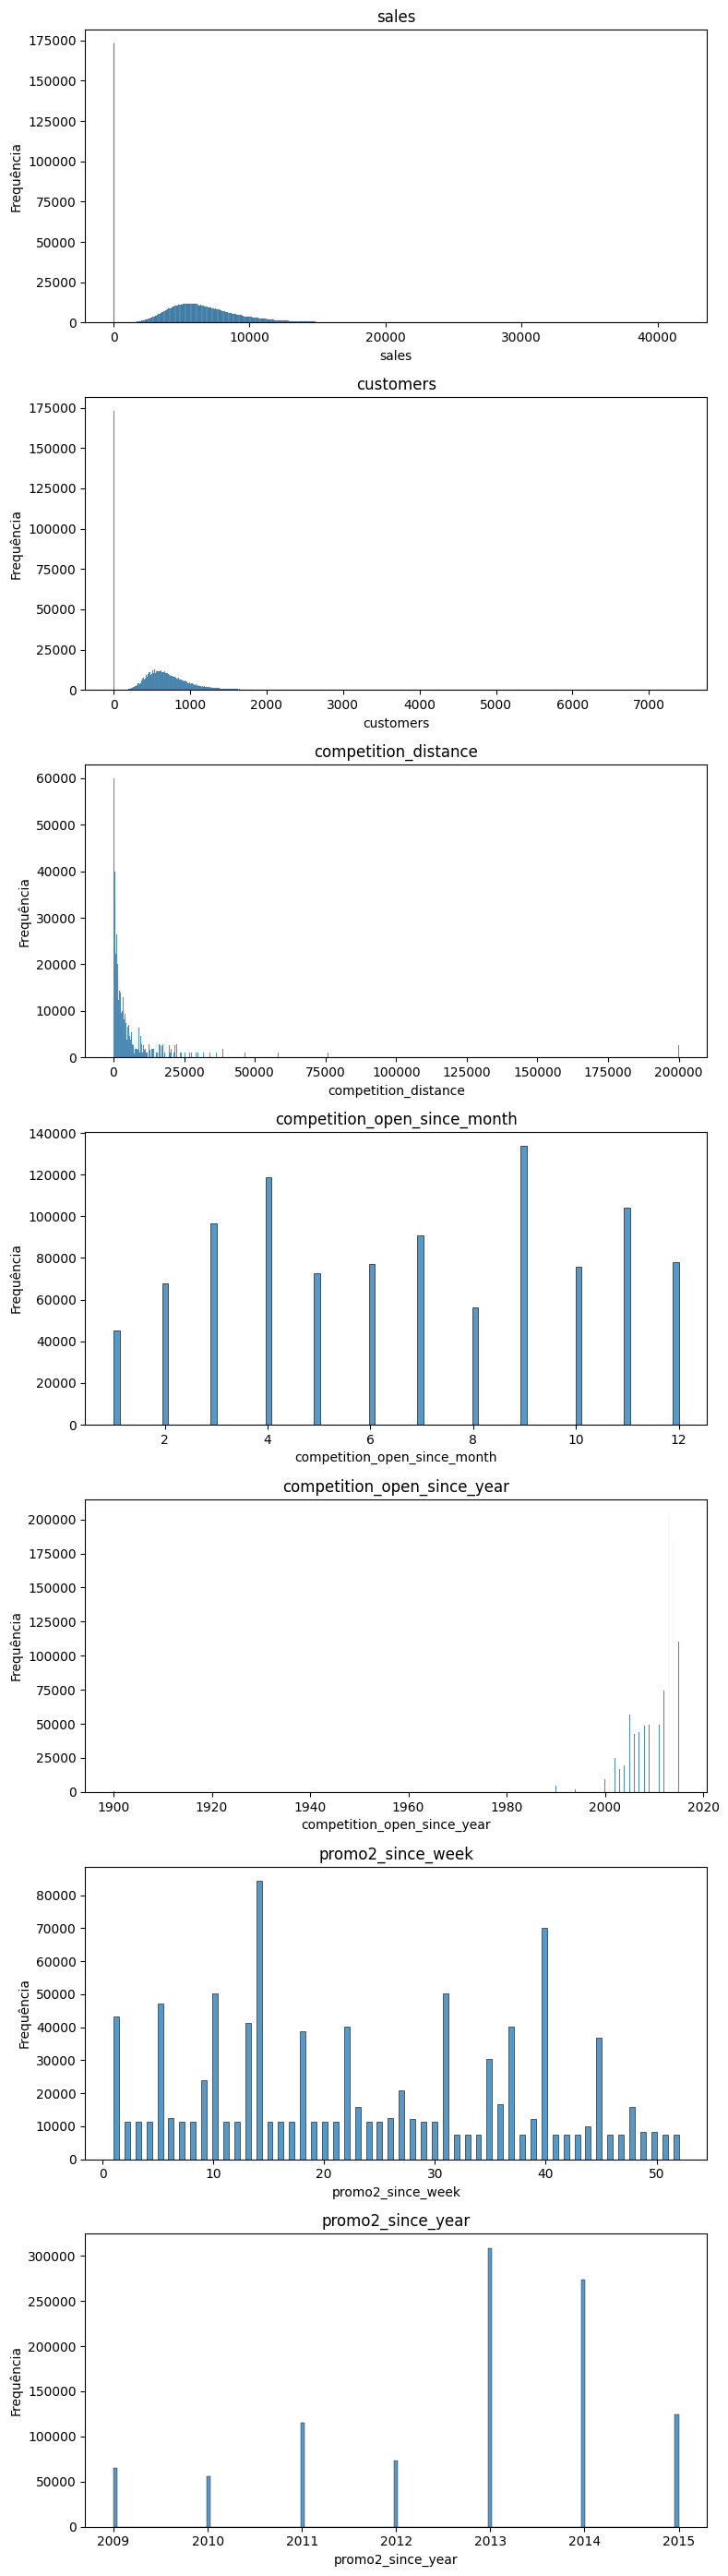

In [18]:
# Plotando a distribuição das variáveis numéricas:

# Criando uma figura com subplots para cada variável numérica
num_vars = attributes_numeric.shape[1]  # Número de colunas (todas numéricas)
fig, axes = plt.subplots(num_vars, 1, figsize=(8, 4 * num_vars))  # Criar subplots

# Se houver apenas uma variável, transformar axes em lista para evitar erro
if num_vars == 1:
    axes = [axes]

# Criar gráficos de histograma para cada variável
for ax, column in zip(axes, attributes_numeric.columns):
    sns.histplot(attributes_numeric[column], ax=ax, kde=False)  # kde=False para não sobrepor curva
    ax.set_title(f'{column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequência')

# Ajustar layout
plt.tight_layout()
plt.show()

### 1.7.1. Variáveis categóricas

In [19]:
# Checando a quantidade de categorias por variável categórica:
print(attributes_categorical.apply( lambda x: x.unique().shape[0] ))

store             1115
day_of_week          7
open                 2
promo                2
state_holiday        4
school_holiday       2
store_type           4
assortment           3
promo2               2
is_promo             2
dtype: int64


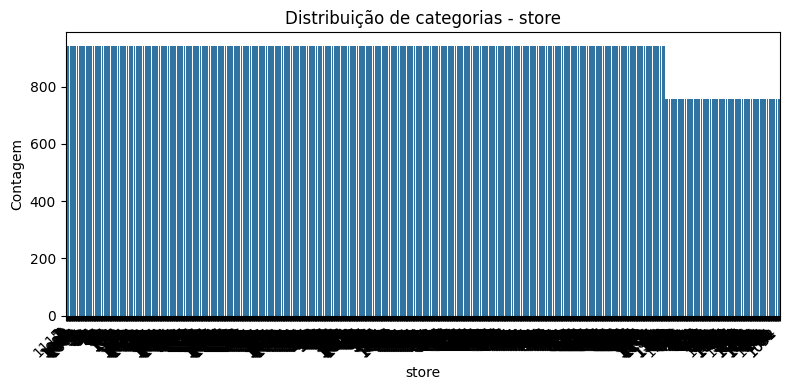

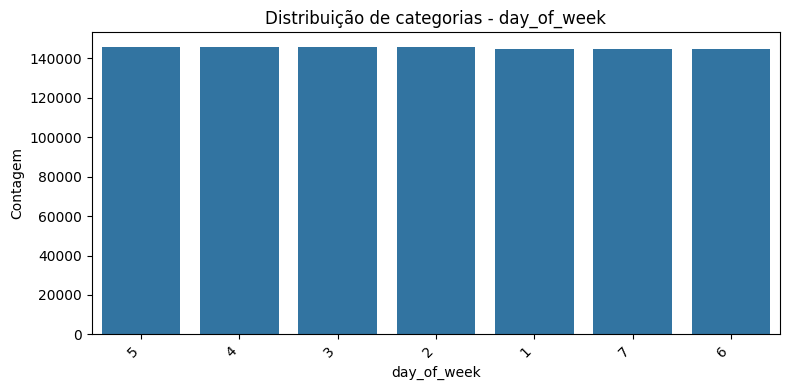

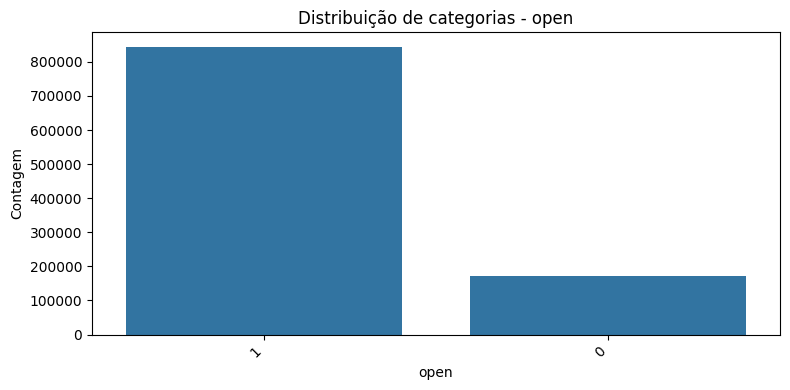

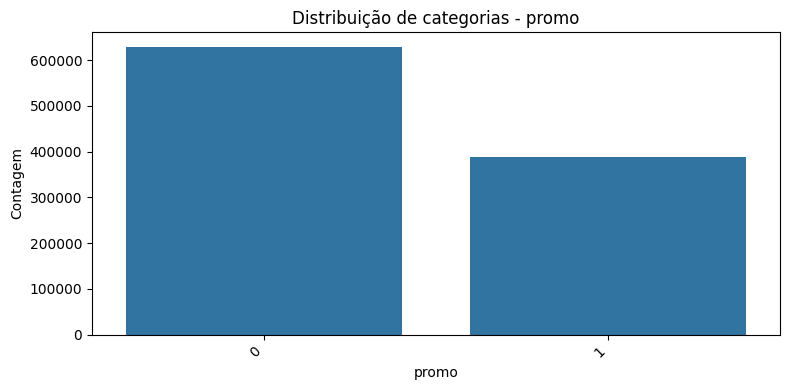

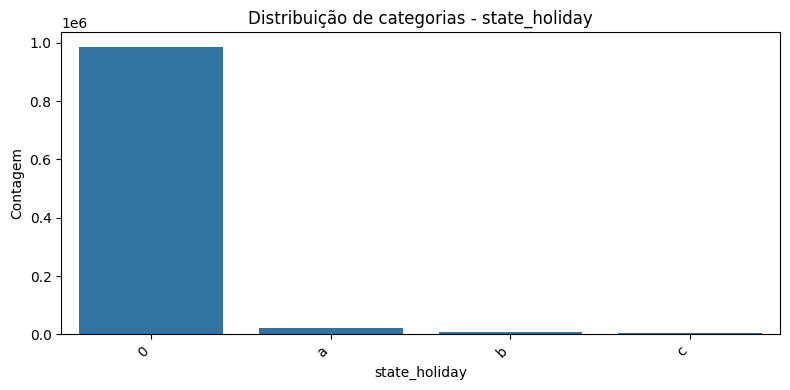

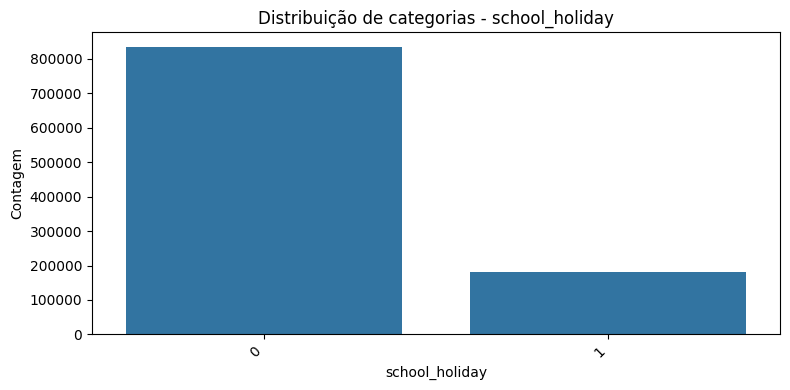

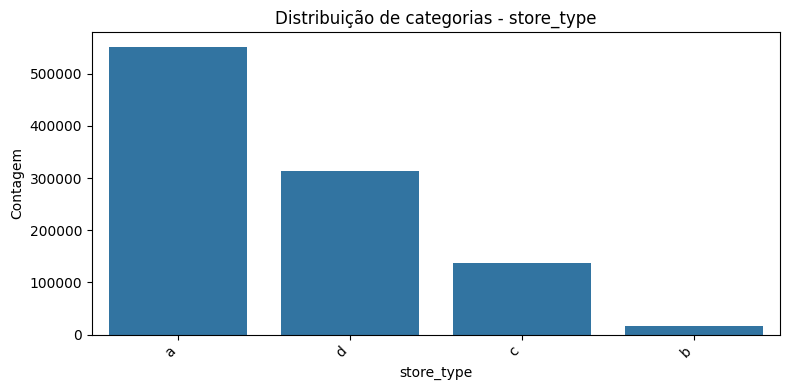

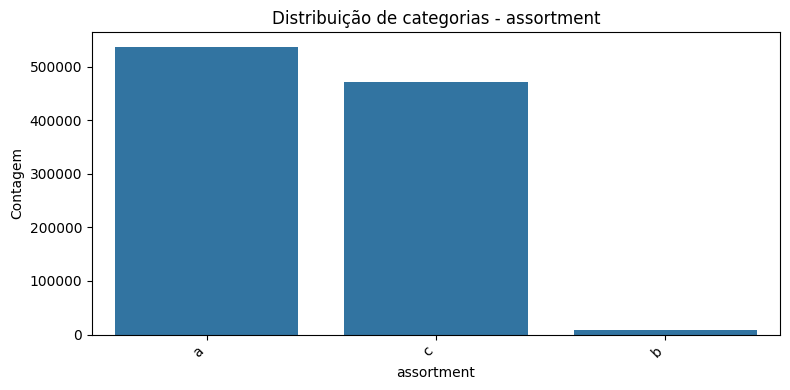

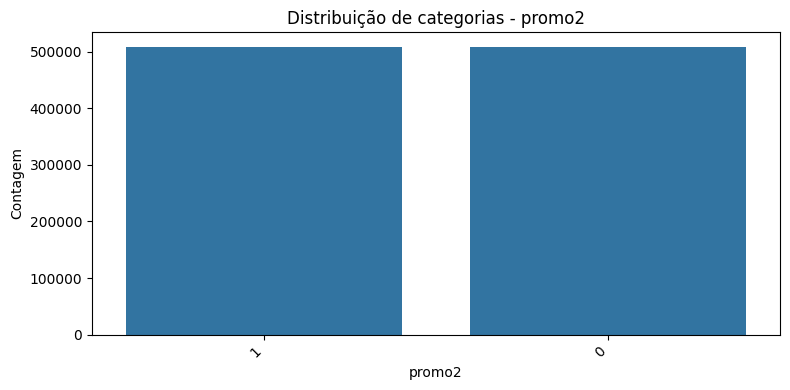

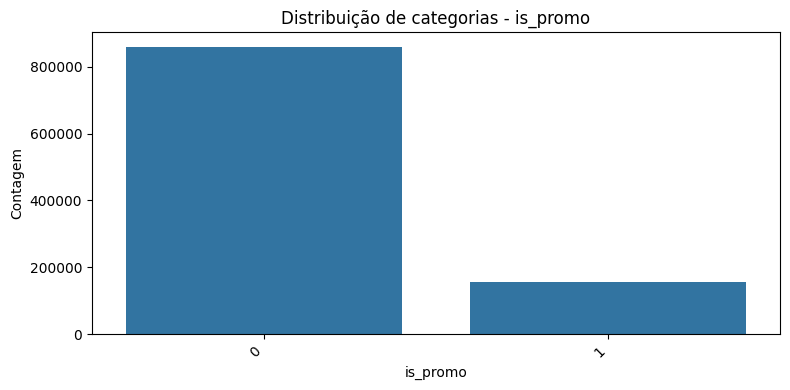

In [20]:
# Gerando um gráfico para cada variável categórica
for coluna in attributes_categorical.columns:
    plt.figure(figsize=(8, 4))
    order = attributes_categorical[coluna].value_counts().index  # ordena pelas categorias mais frequentes
    sns.countplot(data=attributes_categorical, x=coluna, order=order)
    
    plt.title(f'Distribuição de categorias - {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Contagem')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 1.8. Pré-Análise Exploratória

Geração de um relatório no ProfileReport do pacote ydata_profiling. O arquivo html gerado pode ser visualizado no endereço *exports/reports/relatorio_dados_01.html*.

In [21]:
profile = ProfileReport(df_01, title="Relatório de Análise", explorative=True)
profile.to_file("../exports/reports/relatorio_dados_01.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


# Exportação de resultados

In [22]:
df_00.to_pickle('../exports/cicle_exports/01_description/df_00.pkl', compression='gzip')
df_01.to_pickle('../exports/cicle_exports/01_description/df_01.pkl', compression='gzip')